The main part is run_experiment in runner. With signature

<code>def run_experiment(pe_mesh: tuple[int,int],
                   temporal_dims: dict[str,int],
                   m_values: range,
                   config_dr: str, # should contain template architecture, template mapping, workload
                   arch_yaml: str,
                   mapping_yaml: str,
                   tmp_dir: str,
                   bindings: dict[int,str],
                   print_res=True): </code>
                   
It copies the architecture and mapping templates in config_dr, edits them with pe_mesh and temporal_dims, and writes new ones to tmp_dir. Heres some sample usage.

In [1]:
from runner import run_experiment
from pytimeloop.looptree.run import run_looptree
from util import *

bindings = {0:"MainMemory",1:"GlobalBuffer",2:"PEWeightStorage",3:"MACC"}
temps = run_experiment(
    pe_mesh=(512,512),
    temporal_dims={
        'B3':1,'H3':1,
        'E1':512,'P1':512,
        'M2':512,'P2':512,
        'F3':512,'P3':512
    },
    m_values=[1,256,512],
    config_dr=CONFIG_DIR/'current/sequential',
    arch_yaml='architecture.yaml',
    mapping_yaml='mapping_m_tiled.yaml',
    tmp_dir=TMP_DIR,
    bindings=bindings
)

M3=  1  GB=0.0020  lat=786432  E=1.870e+15
M3=256  GB=0.0107  lat=786432  E=1.870e+15
M3=512  GB=0.0195  lat=786432  E=1.870e+15


Here GB is the capacity used of the global buffer, lat is total latency, and E is total energy. I simplified the looptree output to jsut these three metrics but can add logging for it if needed. To run a batch of experiments I do so as follows, first defining my configs. You can do this in any way you want to be honest since the atomic action is just running one experiment with a given PE size, dims, etc. 

In [15]:
# Experiment 1: 1. x axis total number of pes, y axis latency. Seeking to show that as we add PEs both scale, but pipeline (when you segment the tile sizes accordingly)
# is able to use the new compute better

# I vary the PE sizes as follows:

pe_mesh_sizes = [(32,32),
                (64,64),
                (128,128),
                (256,256),
                (512,512),
                (1024,1024)]

# The dimensions here are the ones to be replaced. B3 and H3 are included here for completeness, but the runner defaults them to 1 on line 63 in runner.py. 
# If needed that line in runner can be changed to node['tile_shape'] = temporal_dims[node.get('rank')] to actually use the B3 H3 defined here.

# The commented lines here are what used to be for SM operation. It was found that the SM op was adding very little latency, and in the pipeline just hogging PEs.
# So it was removed following Michaels advice.

spatial_dims_sequential = [
    {
        'B3':1,'H3':1,
        'E1':32,'P1':32,
        # 'M2':32,'P2':32,
        'F3':32,'P3':32
    },
    {
        'B3':1,'H3':1,
        'E1':64,'P1':64,
        # 'M2':64,'P2':64,
        'F3':64,'P3':64
    },
    {
        'B3':1,'H3':1,
        'E1':128,'P1':128,
        # 'M2':128,'P2':128,
        'F3':128,'P3':128
    },
    {
        'B3':1,'H3':1,
        'E1':256,'P1':256,
        # 'M2':256,'P2':256,
        'F3':256,'P3':256
    },
    {
        'B3':1,'H3':1,
        'E1':512,'P1':512,
        # 'M2':512,'P2':512,
        'F3':512,'P3':512
    },
    {
        'B3':1,'H3':1,
        'E1':1024,'P1':1024,
        # 'M2':1024,'P2':1024,
        'F3':1024,'P3':1024
    }]

spatial_dims_pipeline = [
    {
        'B3':1,'H3':1,
        'E1':16,'P1':32,
        # 'M2':12,'P2':32,
        'F3':16,'P3':32
    },
    {
        'B3':1,'H3':1,
        'E1':32,'P1':64,
        # 'M2':24,'P2':64,
        'F3':32,'P3':64
    },
    {
        'B3':1,'H3':1,
        'E1':64,'P1':128,
        # 'M2':48,'P2':128,
        'F3':64,'P3':128
    },
    {
        'B3':1,'H3':1,
        'E1':128,'P1':256,
        # 'M2':96,'P2':256,
        'F3':128,'P3':256
    },
    {
        'B3':1,'H3':1,
        'E1':256,'P1':512,
        # 'M2':182,'P2':512,
        'F3':256,'P3':512
    },{
        'B3':1,'H3':1,
        'E1':512,'P1':1024,
        # 'M2':354,'P2':1024,
        'F3':512,'P3':1024
    }]

m_values = [512]

Now we can run experiments. Again, this can be done in whatever way you desire. The main suggestions are:
- Make sure you separate config directories for your experiments. It makes it easier to keep track of and edit templates.
- In those directories have:
    - an architecture YAML that only the PE size needs to be changed
    - a workload that does not need to be changed
    - a template YAML like the one that is in config/current/sequential or config/current/pipeline that just needs a few dimensions changed.
       - right now the script only changes, besides potentially B3 and H3, dimensions that are in branches under the sequential/pipeline node in the config
       - can be changed if needed

Here is how I went about it.

In [16]:
from runner import run_experiment
from pytimeloop.looptree.run import run_looptree
from util import *

bindings = {0:"MainMemory",1:"GlobalBuffer",2:"PEWeightStorage",3:"MACC"}

experiments = {
    'sequential': (
        CONFIG_DIR / 'current' / 'sequential',
        'mapping_m_tiled.yaml',
        spatial_dims_sequential
    ),
    'pipeline': (
        CONFIG_DIR / 'current' / 'pipeline',
        'mapping.yaml',           
        spatial_dims_pipeline
    ),
}

all_results = {}

for mode, (config_dr, mapping_yaml, dims_list) in experiments.items():
    print(f"\n=== Running {mode.upper()} experiments ===")
    mode_results = {}
    for pe_mesh, temporal_dims in zip(pe_mesh_sizes, dims_list):
        print(f"\n→ PE mesh: {pe_mesh}")
        results = run_experiment(
            pe_mesh=pe_mesh,
            temporal_dims=temporal_dims,
            m_values=m_values,
            config_dr=str(config_dr),
            arch_yaml='architecture.yaml',
            mapping_yaml=mapping_yaml,
            tmp_dir=str(TMP_DIR),
            bindings=bindings,
        )
        mode_results[pe_mesh] = results
    all_results[mode] = mode_results


=== Running SEQUENTIAL experiments ===

→ PE mesh: (32, 32)
M3=512  GB=0.0195  lat=25165824  E=1.870e+15

→ PE mesh: (64, 64)
M3=512  GB=0.0195  lat=6291456  E=1.870e+15

→ PE mesh: (128, 128)
M3=512  GB=0.0195  lat=3145728  E=1.870e+15

→ PE mesh: (256, 256)
M3=512  GB=0.0195  lat=1572864  E=1.870e+15

→ PE mesh: (512, 512)
M3=512  GB=0.0195  lat=786432  E=1.870e+15

→ PE mesh: (1024, 1024)
M3=512  GB=0.0195  lat=786432  E=1.870e+15

=== Running PIPELINE experiments ===

→ PE mesh: (32, 32)
M3=512  GB=0.0195  lat=25198592  E=1.870e+15

→ PE mesh: (64, 64)
M3=512  GB=0.0195  lat=6299648  E=1.870e+15

→ PE mesh: (128, 128)
M3=512  GB=0.0195  lat=1574912  E=1.870e+15

→ PE mesh: (256, 256)
M3=512  GB=0.0195  lat=787456  E=1.870e+15

→ PE mesh: (512, 512)
M3=512  GB=0.0195  lat=393728  E=1.870e+15

→ PE mesh: (1024, 1024)
M3=512  GB=0.0195  lat=393728  E=1.870e+15


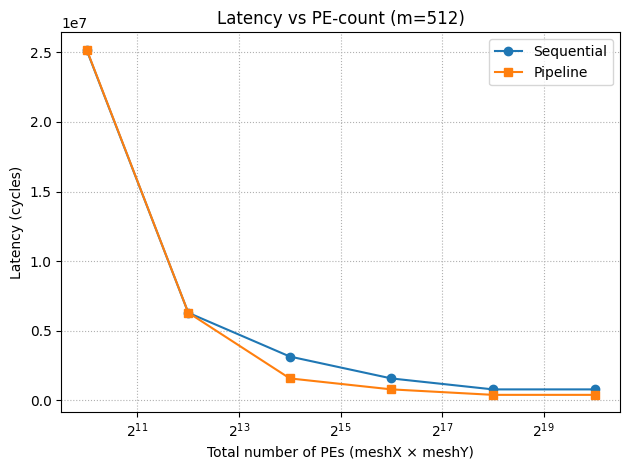

seq latencies [25165824, 6291456, 3145728, 1572864, 786432, 786432]
pipe latencies [25198592, 6299648, 1574912, 787456, 393728, 393728]


In [17]:
import matplotlib.pyplot as plt

m_plot = 512  # choose which m-value to compare

pe_counts = []
lat_seq    = []
lat_pipe   = []

for mesh in pe_mesh_sizes:
    pe_counts.append(mesh[0] * mesh[1])
    lat_seq.append( all_results['sequential'][mesh][m_plot]['latency'] )
    lat_pipe.append( all_results['pipeline'][mesh][m_plot]['latency'] )

plt.figure()
plt.plot(pe_counts, lat_seq,  marker='o', label='Sequential')
plt.plot(pe_counts, lat_pipe, marker='s', label='Pipeline')
plt.xscale('log',  base=2)              # since meshes double
plt.xlabel('Total number of PEs (meshX × meshY)')
plt.ylabel('Latency (cycles)')
plt.title(f'Latency vs PE-count (m={m_plot})')
plt.grid(True, which='both', ls=':')
plt.legend()
plt.tight_layout()
plt.show()

print("seq latencies", lat_seq)
print("pipe latencies", lat_pipe)

The following is a proof of concept for workload informed design. The PE sizes are equivalent to 512x512 PEs.
The idea is that we can do better with the same PEs if we inform our designs entirely on the workload. I.e.
keep one dimension as 128 so that we can allocate 64 by X PE segments to each operation. We know this because E and F max out
at 64, so any more PEs would be unused. 

In [8]:
from runner import run_experiment
from pytimeloop.looptree.run import run_looptree
from util import *

bindings = {0:"MainMemory",1:"GlobalBuffer",2:"PEWeightStorage",3:"MACC"}
temps = run_experiment(
    pe_mesh=(128,2048),
    temporal_dims={
        'B3':1,'H3':1,
        'E1':64,'P1':2048,
        'F3':64,'P3':2048
    },
    m_values=[1,256,512],
    config_dr=CONFIG_DIR/'current/pipeline',
    arch_yaml='architecture.yaml',
    mapping_yaml='mapping.yaml',
    tmp_dir=TMP_DIR,
    bindings=bindings
)

temps = run_experiment(
    pe_mesh=(128,2048),
    temporal_dims={
        'B3':1,'H3':1,
        'E1':128,'P1':2048,
        'F3':128,'P3':2048
    },
    m_values=[1,256,512],
    config_dr=CONFIG_DIR/'current/sequential',
    arch_yaml='architecture.yaml',
    mapping_yaml='mapping_m_tiled.yaml',
    tmp_dir=TMP_DIR,
    bindings=bindings
)

M3=  1  GB=0.0020  lat=393217  E=1.870e+15
M3=256  GB=0.0107  lat=393472  E=1.870e+15
M3=512  GB=0.0195  lat=393728  E=1.870e+15
M3=  1  GB=0.0020  lat=786432  E=1.870e+15
M3=256  GB=0.0107  lat=786432  E=1.870e+15
M3=512  GB=0.0195  lat=786432  E=1.870e+15


Comparing the M3=512 latencies, the values stayed the same to what we graphed above. The extra PEs in the P dimension is going to waste because our P is maxed
at 512. So our previous set up was already allocating enough resources, even though we didn't change the PE array size to fit exactly. I suppose this would help though on 256x256 PEs.

In [9]:
from runner import run_experiment
from pytimeloop.looptree.run import run_looptree
from util import *

bindings = {0:"MainMemory",1:"GlobalBuffer",2:"PEWeightStorage",3:"MACC"}
temps = run_experiment(
    pe_mesh=(128,512),
    temporal_dims={
        'B3':1,'H3':1,
        'E1':64,'P1':512,
        'F3':64,'P3':512
    },
    m_values=[1,256,512],
    config_dr=CONFIG_DIR/'current/pipeline',
    arch_yaml='architecture.yaml',
    mapping_yaml='mapping.yaml',
    tmp_dir=TMP_DIR,
    bindings=bindings
)

temps = run_experiment(
    pe_mesh=(128,512),
    temporal_dims={
        'B3':1,'H3':1,
        'E1':128,'P1':512,
        'F3':128,'P3':512
    },
    m_values=[1,256,512],
    config_dr=CONFIG_DIR/'current/sequential',
    arch_yaml='architecture.yaml',
    mapping_yaml='mapping_m_tiled.yaml',
    tmp_dir=TMP_DIR,
    bindings=bindings
)

M3=  1  GB=0.0020  lat=393217  E=1.870e+15
M3=256  GB=0.0107  lat=393472  E=1.870e+15
M3=512  GB=0.0195  lat=393728  E=1.870e+15
M3=  1  GB=0.0020  lat=786432  E=1.870e+15
M3=256  GB=0.0107  lat=786432  E=1.870e+15
M3=512  GB=0.0195  lat=786432  E=1.870e+15


Using only 256x256 number of PEs, with thoughtful dimensions we were able to get the same performance as 512x512 on both sequential and pipeline.
With fully workload informed decision making on the pipeline, we're not wasting any PEs in our segments. The interesting thing is that when computing
less rows per tile, the latency goes down?

For now I'll recreate the above experiment with this style of PE array and tile sizing.

In [27]:
pe_mesh_sizes_rect = [(16,64),
                (32,128),
                (64,256),
                (128,512),
                (128,2048),
                (128,8192)]

spatial_dims_sequential_rect = [
    {
        'B3':1,'H3':1,
        'E1':16,'P1':64,
        'F3':16,'P3':64
    },
    {
        'B3':1,'H3':1,
        'E1':32,'P1':128,
        'F3':32,'P3':128
    },
    {
        'B3':1,'H3':1,
        'E1':64,'P1':256,
        'F3':64,'P3':256
    },
    {
        'B3':1,'H3':1,
        'E1':128,'P1':512,
        'F3':128,'P3':512
    },
    {
        'B3':1,'H3':1,
        'E1':128,'P1':2048,
        'F3':128,'P3':2048
    },
    {
        'B3':1,'H3':1,
        'E1':128,'P1':8192,
        'F3':128,'P3':8192
    }]

spatial_dims_pipeline_rect = [
    {
        'B3':1,'H3':1,
        'E1':8,'P1':64,
        'F3':8,'P3':64
    },
    {
        'B3':1,'H3':1,
        'E1':16,'P1':128,
        'F3':16,'P3':128
    },
    {
        'B3':1,'H3':1,
        'E1':32,'P1':256,
        'F3':32,'P3':256
    },
    {
        'B3':1,'H3':1,
        'E1':64,'P1':512,
        'F3':64,'P3':512
    },
    {
        'B3':1,'H3':1,
        'E1':64,'P1':2048,
        'F3':64,'P3':2048
    },{
        'B3':1,'H3':1,
        'E1':64,'P1':8192,
        'F3':64,'P3':8192
    }]

m_values = [512]

from runner import run_experiment
from pytimeloop.looptree.run import run_looptree
from util import *

bindings = {0:"MainMemory",1:"GlobalBuffer",2:"PEWeightStorage",3:"MACC"}

experiments = {
    'sequential': (
        CONFIG_DIR / 'current' / 'sequential',
        'mapping_m_tiled.yaml',
        spatial_dims_sequential_rect
    ),
    'pipeline': (
        CONFIG_DIR / 'current' / 'pipeline',
        'mapping.yaml',           
        spatial_dims_pipeline_rect
    ),
}

all_results_rect = {}

for mode, (config_dr, mapping_yaml, dims_list) in experiments.items():
    print(f"\n=== Running {mode.upper()} experiments ===")
    mode_results = {}
    for pe_mesh, temporal_dims in zip(pe_mesh_sizes_rect, dims_list):
        print(f"\n→ PE mesh: {pe_mesh}")
        results = run_experiment(
            pe_mesh=pe_mesh,
            temporal_dims=temporal_dims,
            m_values=m_values,
            config_dr=str(config_dr),
            arch_yaml='architecture.yaml',
            mapping_yaml=mapping_yaml,
            tmp_dir=str(TMP_DIR),
            bindings=bindings,
        )
        mode_results[pe_mesh] = results
    all_results_rect[mode] = mode_results


=== Running SEQUENTIAL experiments ===

→ PE mesh: (16, 64)
M3=512  GB=0.0195  lat=25165824  E=1.870e+15

→ PE mesh: (32, 128)
M3=512  GB=0.0195  lat=6291456  E=1.870e+15

→ PE mesh: (64, 256)
M3=512  GB=0.0195  lat=1572864  E=1.870e+15

→ PE mesh: (128, 512)
M3=512  GB=0.0195  lat=786432  E=1.870e+15

→ PE mesh: (128, 2048)
M3=512  GB=0.0195  lat=786432  E=1.870e+15

→ PE mesh: (128, 8192)
M3=512  GB=0.0195  lat=786432  E=1.870e+15

=== Running PIPELINE experiments ===

→ PE mesh: (16, 64)
M3=512  GB=0.0195  lat=25198592  E=1.870e+15

→ PE mesh: (32, 128)
M3=512  GB=0.0195  lat=6299648  E=1.870e+15

→ PE mesh: (64, 256)
M3=512  GB=0.0195  lat=1574912  E=1.870e+15

→ PE mesh: (128, 512)
M3=512  GB=0.0195  lat=393728  E=1.870e+15

→ PE mesh: (128, 2048)
M3=512  GB=0.0195  lat=393728  E=1.870e+15

→ PE mesh: (128, 8192)
M3=512  GB=0.0195  lat=393728  E=1.870e+15


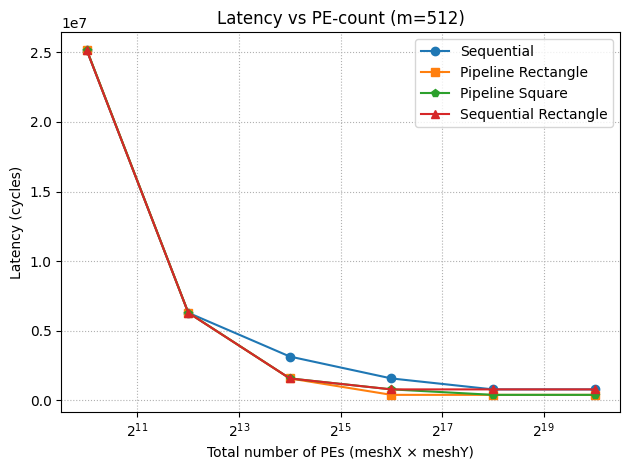

seq latencies [25165824, 6291456, 3145728, 1572864, 786432, 786432]
rect seq latencies [25165824, 6291456, 1572864, 786432, 786432, 786432]
pipe latencies [25198592, 6299648, 1574912, 787456, 393728, 393728]
rect pipe latencies [25198592, 6299648, 1574912, 393728, 393728, 393728]


In [26]:
import matplotlib.pyplot as plt

m_plot = 512  # choose which m-value to compare

pe_counts_rect = []
lat_seq_rect    = []
lat_pipe_rect   = []

for mesh in pe_mesh_sizes_rect:
    pe_counts_rect.append(mesh[0] * mesh[1])
    lat_seq_rect.append( all_results_rect['sequential'][mesh][m_plot]['latency'] )
    lat_pipe_rect.append( all_results_rect['pipeline'][mesh][m_plot]['latency'] )

plt.figure()
plt.plot(pe_counts, lat_seq,  marker='o', label='Sequential')
plt.plot(pe_counts, lat_pipe_rect, marker='s', label='Pipeline Rectangle')
plt.plot(pe_counts, lat_pipe, marker='p', label='Pipeline Square')
plt.plot(pe_counts, lat_seq_rect,  marker='^', label='Sequential Rectangle')
plt.xscale('log',  base=2)              # since meshes double
plt.xlabel('Total number of PEs (meshX × meshY)')
plt.ylabel('Latency (cycles)')
plt.title(f'Latency vs PE-count (m={m_plot})')
plt.grid(True, which='both', ls=':')
plt.legend()
plt.tight_layout()
plt.show()

print("seq latencies", lat_seq)
print("rect seq latencies", lat_seq_rect)
print("pipe latencies", lat_pipe)
print("rect pipe latencies", lat_pipe_rect)

With rectangular PE sizes and more informed pipeline segment sizes we're able to achieve the plateu faster i.e. get 512x512 performance on 256x256 PEs.
For completeness we should show that increasing the PE dimension used by E and F doesn't afford the same speed up. 

Next experiments:
1. Varying PE array size in both dimensions seeing speed up over sequential if any. Covered on 2nd part.
2. Moving P3 loop to be above M3 and removing all P loops from branches.
3. Changing the GB to be smaller and change tile shapes to see impact of GB, 128KB etc.
4. Could also show adding B, H tile doesn't do anything. Tiling smartly
   
Thing to ask: how do we know whether a spatial loop is on the meshX or meshY axis? 
Todo: switch meshX and meshY and see if theres a diff

Do a small sweep for B,H on current experiments